<a href="https://colab.research.google.com/github/AmrAshrafIbrahim/Image-Segmentation/blob/main/Assignment_2_PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


Masking for evaluation (ask TA)

why NC is the worst?

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
import imageio
#from validation import validate_clustering
from sklearn.cluster import SpectralClustering
from skimage.transform import rescale, resize

In [ ]:
def K_means(image,nk):
  A=image
  ll=[]
  for kk in range(nk,nk+1,2):
    C=np.zeros((kk,3))
    C[0]=A[0]
    C[kk-1]=A[154400]
    v=int(154401/kk)
    for i in range(1,kk-1): # set the intial values for centroids
      C[i]=A[v]
      v=v+int(154401/kk)

    C2=np.zeros((kk,3))
    C2[:,:]=C[:,:]
    N=0
    ED_array2=np.zeros((kk,154401))
    itr=0
    while (itr<11):
      itr+=1
      for i in range(0,kk):
        for j in range(0,154401):
          d=C2[i]-A[j]
          ED=0
          for s in range(0,3):
            ED+=d[s]*d[s]
          ED_array2[i,j]=math.sqrt(ED)
    
      y2=np.zeros((154401,1))
      c=np.zeros((154401*kk,3))
      ic=np.zeros([kk, 1], dtype = int)
      for m in range(0,154401):
        idx = ED_array2[:,m].argsort()[::1] 
        c[int(idx[0])*154401+ic[idx[0]]]=A[m]
        ic[idx[0]]+=1
        y2[m]=idx[0]

      C2_test=np.zeros((kk,3))

      for i in range(0,kk):
        if(int(ic[i])==1) : C2_test[i]=c[i*154401]
        else : C2_test[i]=np.mean(c[i*154401:i*154401+int(ic[i]),:],axis=0)

      flag=1
      for i in range(0,kk):
        if(C2_test[i,0]!=C2[i,0] or C2_test[i,1]!=C2[i,1]): 
          flag=0
          break
      if(flag==1):break
    ll.append(y2)
  return y2

In [ ]:
import numpy as np
import scipy.io


def read_GT():
  GT_images = []
  for i in range(1,51):
    x=[]
    mat = scipy.io.loadmat('/content/drive/MyDrive/imageSegmentation/testGT/gt ('+str(i)+').mat')
    for k in np.squeeze(mat['groundTruth']).reshape(-1):
       x.append(k[0][0][0])
    GT_images.append(x)
  return GT_images

def read_jpg():
  images = []
  for i in range(1,51):
    images.append(img.imread('/content/drive/MyDrive/imageSegmentation/test/img ('+str(i)+').jpg'))
  return images

def drawxc(images,GT_images):
  for i in range(0,50):
    num = len(GT_images[i]) + 1  # +1 for the image
    fig, ax = plt.subplots(1, num, figsize=(15,15))
    ax[0].imshow(images[i])
    for j in range(1,num):
        ax[j].imshow(GT_images[i][j-1])
    plt.show()

def kmeans(images,k):
  results=[]
  for image in images:
    x=image.reshape((-1,3))
    kmean_labels=K_means(x,k)
    results.append(kmean_labels.reshape(image.shape[:-1]))
  return results

images = read_jpg()
GT_images = read_GT()
#drawxc(read_jpg(), GT_images)

k = [3,5,7,9,11]
results=[]
# for i in k:
#   results.append(kmeans(images,i))  # result = 5 rows each is one of the k and each row has 10 images ,each image is a matrix

In [ ]:
#np.save('/content/drive/MyDrive/imageSegmentation/results',results)
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
results = np.load('/content/drive/MyDrive/imageSegmentation/results.npy')

In [ ]:
drawxc(images, GT_images)

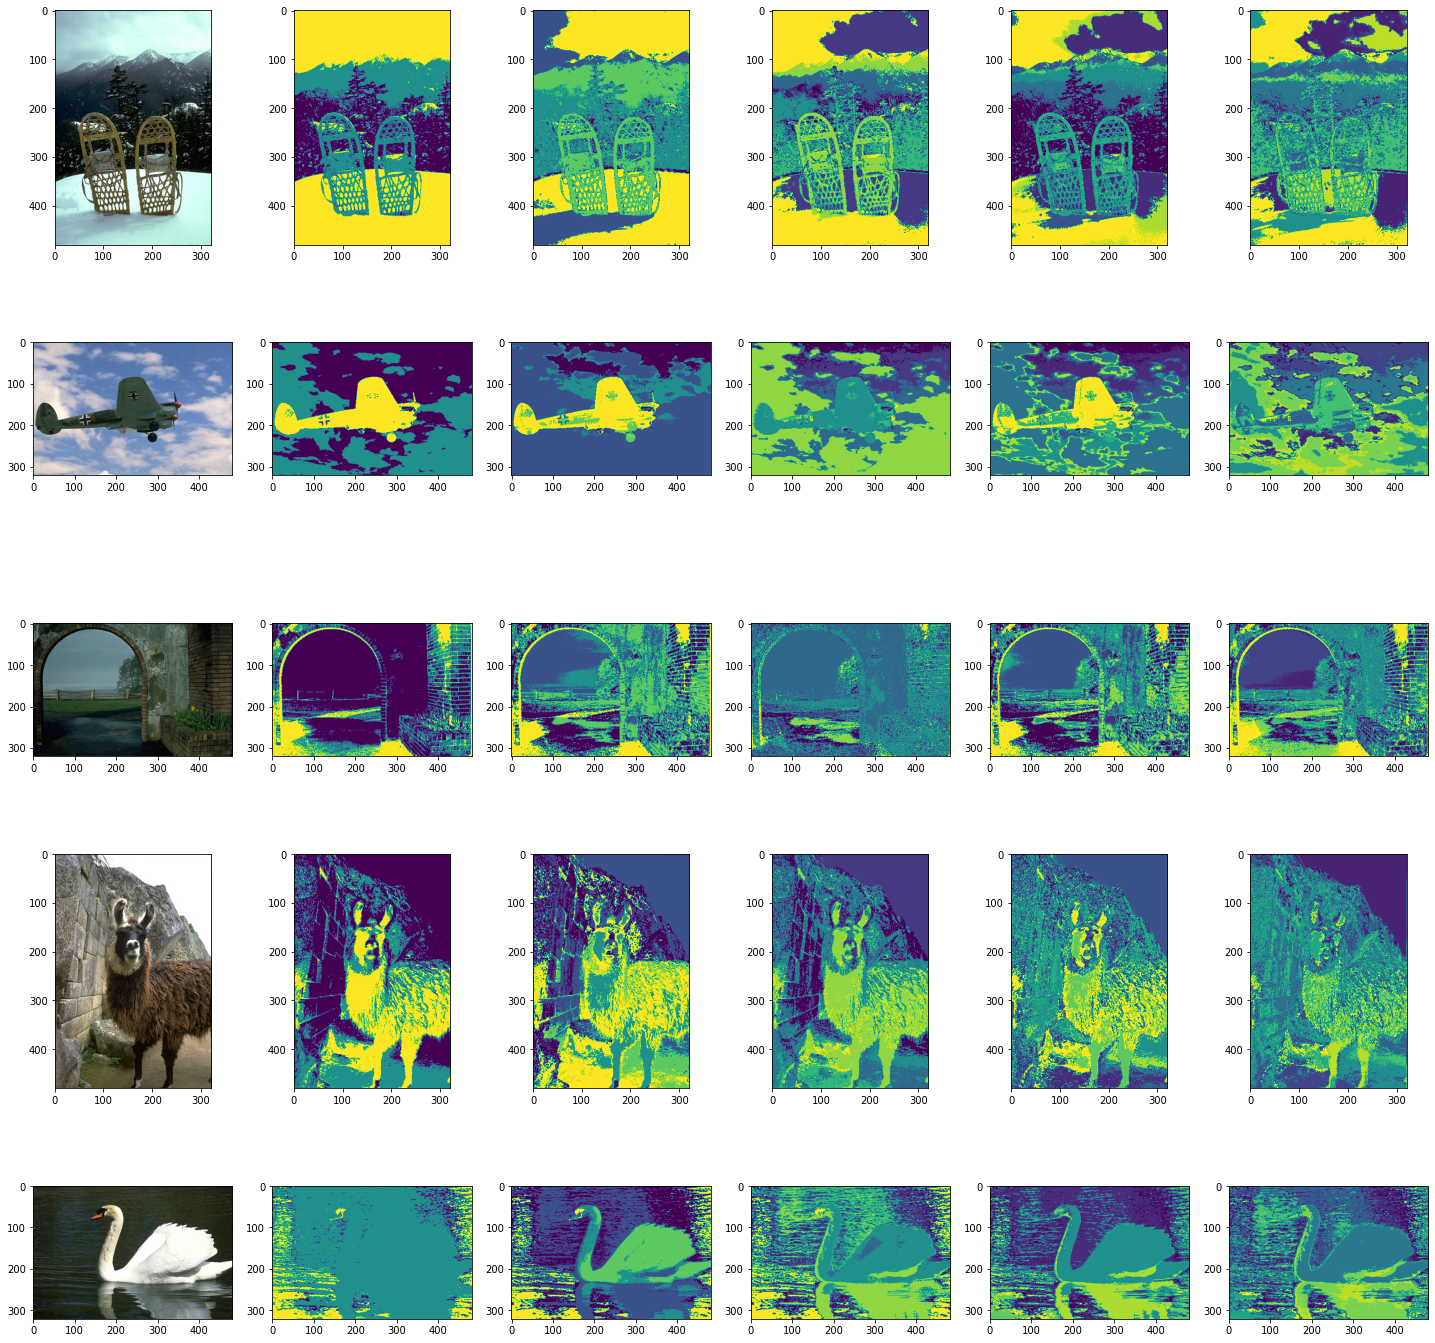

In [ ]:
fig, ax = plt.subplots(5, 6, figsize=(25,25))
for j in range(0,5):
  xxx = images[j]
  ax[j][0].imshow(xxx)
  for i in range(1,6):
    xxx = results[i-1][j]
    ax[j][i].imshow(xxx)
plt.show()

In [ ]:
def Fmeasure(contingM):
  score = 0
  for i in range(0,len(contingM[0,:])):
    mx = np.argmax(contingM[:,i])
    prec = contingM[mx,i]/np.sum(contingM[:,i])
    recall = contingM[mx,i]/np.sum(contingM[mx,:])
    score+= (2 * prec * recall) / (prec + recall)
  return score/len(contingM[0,:])

def Entropy(contingM):
  Entro = 0
  s=0
  for i in range(0,len(contingM[0,:])):
    #s=0  
    for j in range(0,len(contingM)):
      if(contingM[j][i] != 0.0):
          v=contingM[j][i]/sum(contingM[:,i])
          s-=(v)*math.log2(v)
    Entro+=(sum(contingM[:,i])/(154401*3))*s
  return Entro


In [ ]:
#y=results[0][9]

avgFMDataset = []
avgENTDataset = []
TotavgFMk = []
Totfmeasures= []
TotavgENTk = []
Totentropy= []

for IM in range(0,len(GT_images)):
  avgFMk = []
  fmeasures= []
  avgENTk = []
  entropy= []
  for i in range(0,len(k)):
    M = len(GT_images[IM])
    for j in range(0,M):
      contingM = contingency_matrix(GT_images[IM][j],results[i][IM])
      fmeasures.append(Fmeasure(contingM))
      entropy.append(Entropy(contingM))
    Totfmeasures.append(fmeasures)
    Totentropy.append(entropy)
    avgFMk.append(sum(fmeasures[M*i:M*(i+1)])/M)
    avgENTk.append(sum(entropy[M*i:M*(i+1)])/M)
  TotavgFMk.append(avgFMk)
  TotavgENTk.append(avgENTk)
  avgFMDataset.append(sum(TotavgFMk[IM])/len(k))
  avgENTDataset.append(sum(TotavgENTk[IM])/len(k))

for mk in range(0,10):
  for sk in range(0,5):
    print(TotavgFMk[mk][sk])
  print('------------------------------------------')
print('*************************************************************')
for mk in range(0,10):
  for sk in range(0,5):
    print(TotavgENTk[mk][sk])
  print('------------------------------------------')
print('*****************************************************')
for kk in range(0,10):
  print(avgFMDataset[kk])
print('------------------------------------------')
for kk in range(0,10):
  print(avgENTDataset[kk])

# **New Update**

In [ ]:
def mask(Gt,ksd):
  cop=np.copy(Gt)
  flat_array = cop.flatten()
  count_arr = np.bincount(flat_array)
  idx = count_arr.argsort()[::-1]
  for l in range(0,len(cop[:])):
   for m in range(0,len(cop[0,:])):
     if(l<481 and m<321):
      if(cop[l][m] not in idx[0:ksd-1]) : cop[l][m]=0
  return cop

In [ ]:
def Fmeasure(contingM):
  score = 0
  for i in range(0,len(contingM[0,:])):
    mx = np.argmax(contingM[:,i])
    prec = contingM[mx,i]/np.sum(contingM[:,i])
    recall = contingM[mx,i]/np.sum(contingM[mx,:])
    score+= (2 * prec * recall) / (prec + recall)
  return score/len(contingM[0,:])

def Entropy(contingM):
  Entro = 0
  s=0
  for i in range(0,len(contingM[0,:])):
    s=0  
    for j in range(0,len(contingM)):
      if(contingM[j][i] != 0.0):
          v=contingM[j][i]/sum(contingM[:,i])
          s-=(v)*math.log2(v)
    Entro+=(sum(contingM[:,i])/(154401))*s  #154401*3
  return Entro


In [ ]:
#y=results[0][9]
k = [3,5,7,9,11]
avgFMDataset = []
avgENTDataset = []
TotavgFMk = []
Totfmeasures= []
TotavgENTk = []
Totentropy= []

for IM in range(0,len(GT_images)):
  avgFMk = []
  fmeasures= []
  avgENTk = []
  entropy= []
  for i in range(0,len(k)):
    M = len(GT_images[IM])
    for j in range(0,M):
      if(len(np.unique(GT_images[IM][j]))>k[i]) : GTR=mask(GT_images[IM][j],k[i])
      else : GTR=GT_images[IM][j]
      contingM = contingency_matrix(GTR,results[i][IM])
      fmeasures.append(Fmeasure(contingM))
      entropy.append(Entropy(contingM))
    Totfmeasures.append(fmeasures)
    Totentropy.append(entropy)
    avgFMk.append(sum(fmeasures[M*i:M*(i+1)])/M)
    avgENTk.append(sum(entropy[M*i:M*(i+1)])/M)
  TotavgFMk.append(avgFMk)
  TotavgENTk.append(avgENTk)
  avgFMDataset.append(sum(TotavgFMk[IM])/len(k))
  avgENTDataset.append(sum(TotavgENTk[IM])/len(k))

for mk in range(0,10):
  for sk in range(0,5):
    print(TotavgFMk[mk][sk])
  print('------------------------------------------')
print('*************************************************************')
for mk in range(0,10):
  for sk in range(0,5):
    print(TotavgENTk[mk][sk])
  print('------------------------------------------')
print('*****************************************************')
for kk in range(0,10):
  print(avgFMDataset[kk])
print('------------------------------------------')
for kk in range(0,10):
  print(avgENTDataset[kk])

# **4. Big Picture (A)**

In [ ]:
def drawK5(images,results,GT_images,mode):
  for i in range(0,5):
    if(mode==0 or mode ==1):
      num = len(GT_images[i]) + 2  # +1 for the image
      fig, ax = plt.subplots(1, num, figsize=(15,15))
      ax[0].imshow(images[i])
      if(mode==0) : ax[1].imshow(results[1][i])
      elif(mode==1) : ax[1].imshow(results[i])
      for j in range(2,num):
          ax[j].imshow(GT_images[i][j-2])
      plt.show()
    else :
      fig, ax = plt.subplots(1, 3, figsize=(15,15))
      ax[0].imshow(images[i])
      ax[1].imshow(results[1][i])
      ax[2].imshow(GT_images[i])
      ax[0].set_title('Original Image '+str(i+1))
      ax[1].set_title('Image Using K_means'+str(i+1))
      ax[2].set_title('Image Using NC'+str(i+1))
      plt.show()

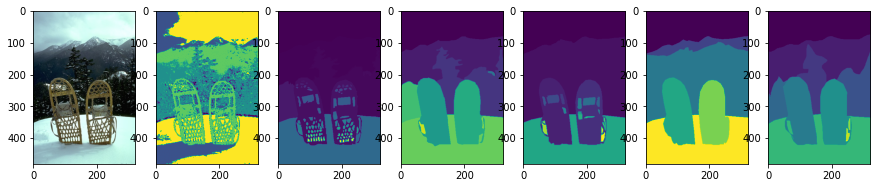

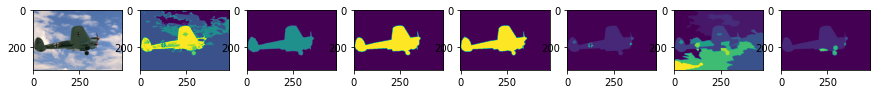

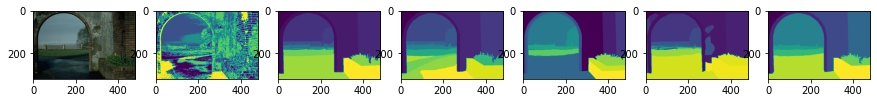

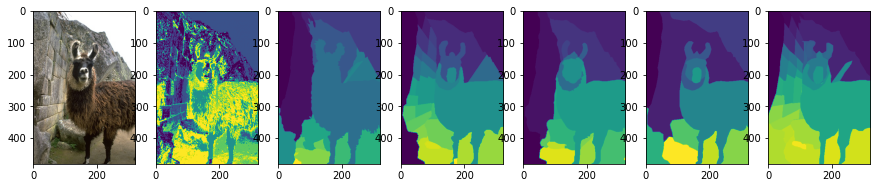

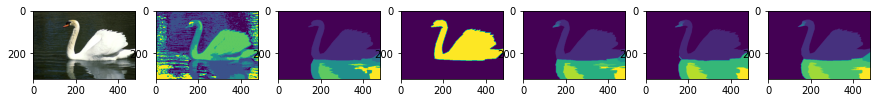

In [ ]:
drawK5(images,results,GT_images,0)

# **(B)**

In [ ]:
from sklearn.neighbors import kneighbors_graph

def ncut(Data,nn,sze):
    dist=np.zeros((sze,sze))
    for d in range(0,sze):
        for c in range(0,sze):
          dist[d,c]=np.linalg.norm(Data[d]-Data[c])
    Adj = kneighbors_graph( dist , nn , mode='connectivity', include_self=False).toarray()
    Degree = np.diag(np.sum(Adj, axis=1))
    L = Degree - Adj
    La = np.dot(np.linalg.inv(Degree),L)
    eigenvalues,eigenvectors=np.linalg.eigh(La)
    idx = eigenvalues.argsort()[::1]
    arreigenvalues = eigenvalues[idx]
    arreigenvectors = eigenvectors[:,idx]
    return arreigenvalues,arreigenvectors

In [ ]:
import cv2

# eigval = []
# eigvec = []
resized_data = []
for im in range(0,5):
  scale = 0.25
  image = images[im]
  width = int(image.shape[1] * scale)
  height = int(image.shape[0] * scale)
  dsize = (width, height)
  resized_data.append(cv2.resize(np.copy(image), dsize))
  # x,y = ncut(resized_data[im].reshape((-1,3)),5,width*height)
  # eigval.append(x)
  # eigvec.append(y)

# np.save('/content/drive/MyDrive/imageSegmentation/eigval',eigval)
# np.save('/content/drive/MyDrive/imageSegmentation/eigvec',eigvec)

In [ ]:
eigval=np.load('/content/drive/MyDrive/imageSegmentation/eigval.npy')
eigvec=np.load('/content/drive/MyDrive/imageSegmentation/eigvec.npy')

In [ ]:
U=[]
Y=[]
for j in range(0,5):
  for i in range(0,len(eigval[0])): #0-> 513 ,  
    if(eigval[j][i]>0) : break
  U.append(eigvec[j][:,i:i+5])
for j in range(0,5):
  cc=np.zeros((9600,5))
  for i in range(0,9600):
    if(np.linalg.norm(U[j][i]) != 0) : cc[i] = U[j][i]/np.linalg.norm(U[j][i])
  Y.append(cc)

In [ ]:
NCR=[]
for i in range(0,5):
  kmean = KMeans(n_clusters=5,random_state=0).fit(Y[i])
  NCR.append(kmean.labels_.reshape(resized_data[i].shape[:-1]))

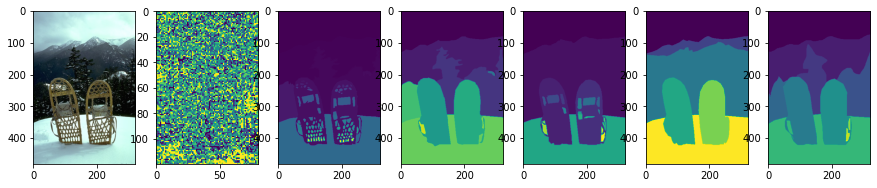

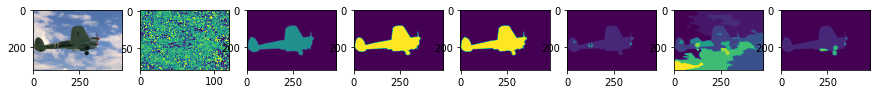

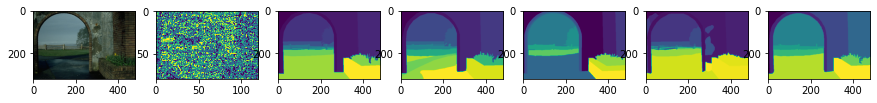

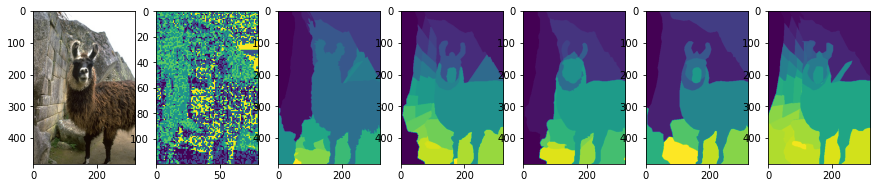

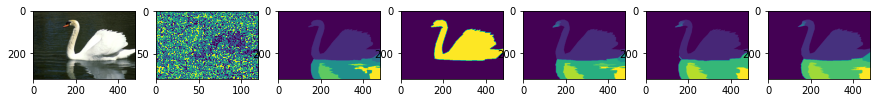

In [ ]:
drawK5(images,NCR,GT_images,1)   #impr by inc k for NC

# **(C)**

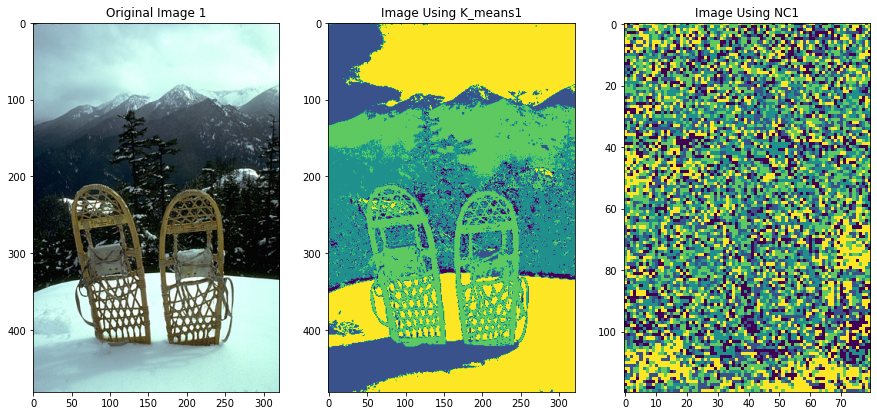

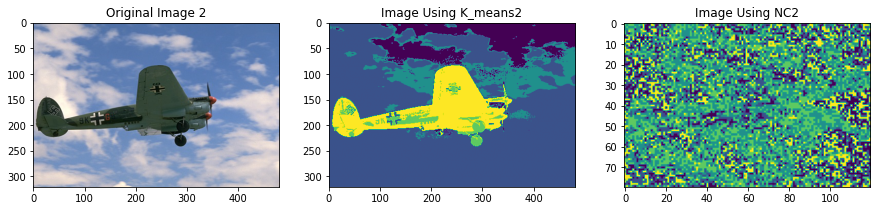

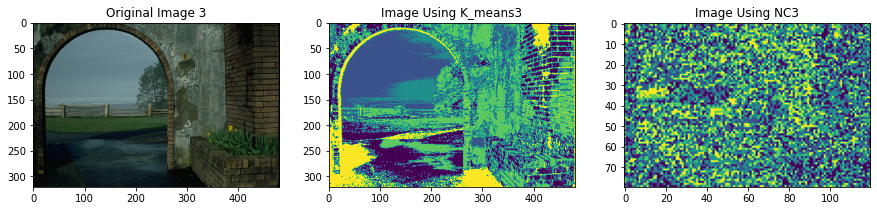

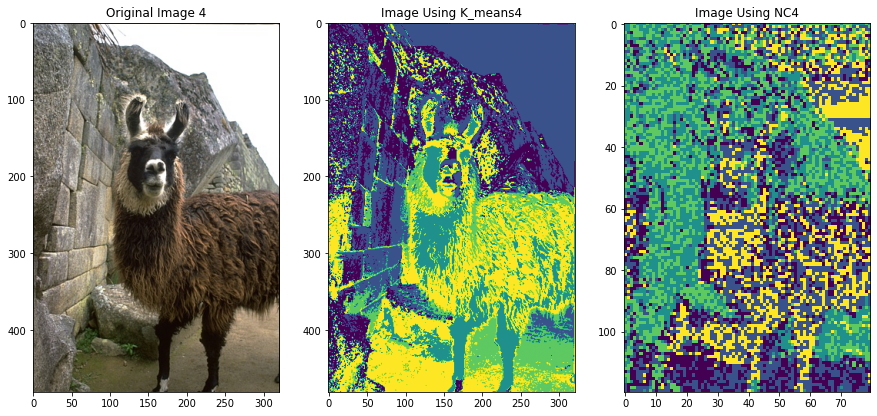

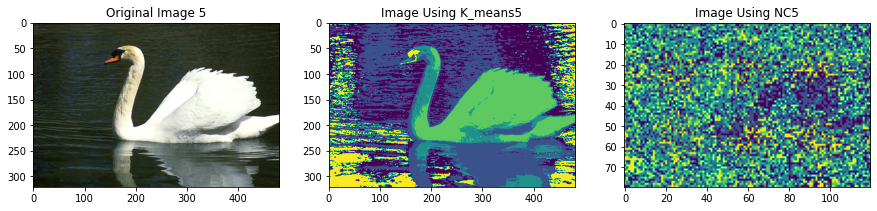

In [ ]:
drawK5(images,results,NCR,2)

# **Extra**

In [ ]:
def SpatialLayout(images,k):
  resultsImp = []
  for i in range(0,5):
    a = images[i].shape[0]
    b = images[i].shape[1]
    x = np.arange(a)
    y = np.arange(b)
    x, y = np.meshgrid(x,y)
    image5F = np.concatenate((images[i],x.reshape(a,b,1), y.reshape(a,b,1)), axis=2)
    x=image5F.reshape((-1,5))
    kmean = KMeans(n_clusters=k,random_state=0).fit(x)
    resultsImp.append(kmean.labels_.reshape(images[i].shape[:-1]))
  return resultsImp

In [ ]:
def SpatialLayoutTrail(images,k,results):
  resultsImp = []
  for i in range(0,5):
    a = images[i].shape[0]
    b = images[i].shape[1]
    y=images[i].reshape((-1,3))
    kmeany = KMeans(n_clusters=k,random_state=0).fit(y)
    image5F = np.concatenate((images[i],kmeany.labels_.reshape((a,b,1)), results[1][i].reshape((a,b,1))), axis=2)
    x=image5F.reshape((-1,5))
    kmean = KMeans(n_clusters=k,random_state=0).fit(x)
    resultsImp.append(kmean.labels_.reshape(images[i].shape[:-1]))
  return resultsImp

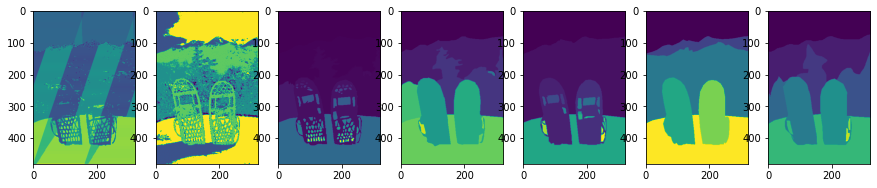

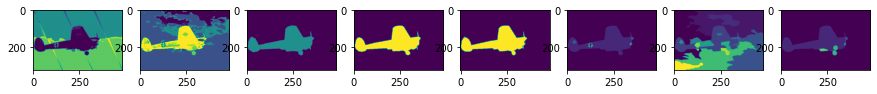

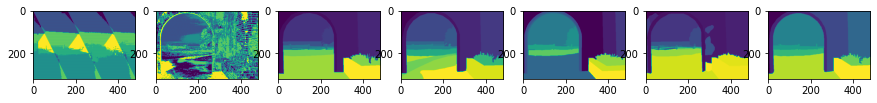

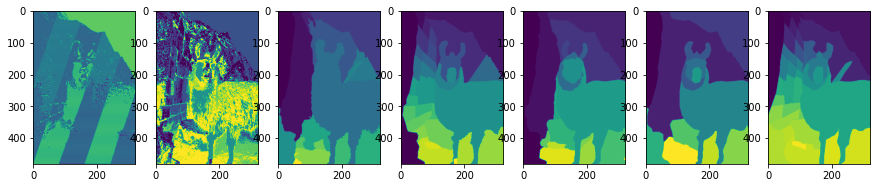

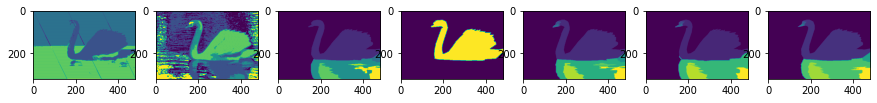

In [ ]:
resultsImp = SpatialLayout(images[0:5],5)
drawK5(resultsImp,results,GT_images,0)

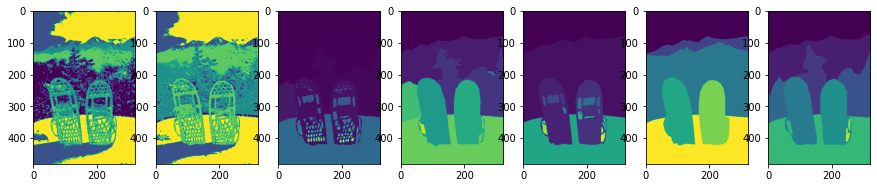

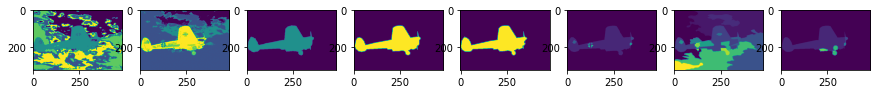

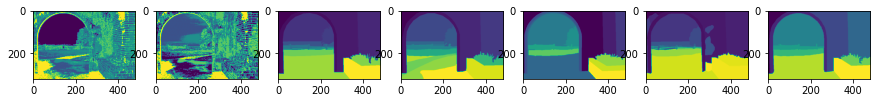

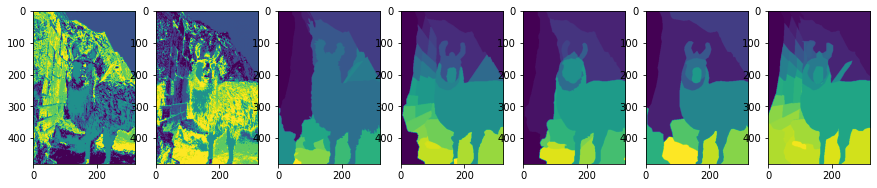

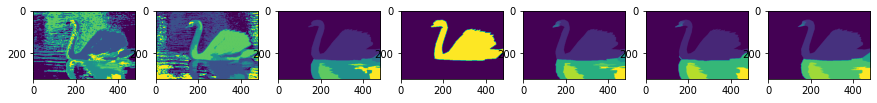

In [ ]:
resultsImpTrail = SpatialLayoutTrail(images[0:5],5,results)
drawK5(resultsImpTrail,results,GT_images,0)

(-0.5, 480.5, 320.5, -0.5)

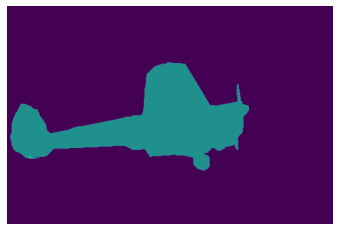

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplot = plt.imshow(GT_images[1][0])
plt.axis('off')